# Volleyball Arm Swing Physics Simulation with 3D Pendulum
#### By Antoine Assaf
#### 4/15/2025

## Introduction

In volleyball, the mechanics of a powerful arm swing are central to effective offensive play, yet the physics of such motion is often intuitive and underexplored quantitatively. This project presents a computational biomechanics framework for simulating and analyzing volleyball arm swings using a 3D double pendulum model, guided by real-world pose data.

The model treats the upper arm and forearm as two rigid links connected by spherical joints, evolving under the influence of gravity, damping, and timed biomechanical torque pulses. Shoulder motion is extracted directly from video using MediaPipe's pose tracking, and serves as the dynamic driving path for the pendulum base. A Gaussian-based torque pulse model approximates muscle activation during the swing, with separate impulses controlling extension (joint straightening) and rotation (torso swing).

To explore the effects of swing strategy and technique, three types of swings (straight, bow-and-arrow, and circular) are recorded for two volleyball athletes (myself and my friend Carly). Simulations include both parameter sweeps and Monte Carlo searches to determine the optimal timing and ratio of biomechanical impulses that maximize hand speed and hand height. This report shows that the pendulum model not only produces plausible dynamics, but also reflects physical intuition: swings that pass lower through the body tend to generate more hand speed due to increased arc length and torque leverage. And, as such, further expansion of this model can be used for volleyball coaches and athletes.

By combining pose detection, physics-based modeling, and computational optimization, this project provides a detailed and realistic picture of upper-limb coordination in volleyball—one that connects emperical data from experiments and insight from current volleyball research.


## Installs and Imports
To get started, I first install MediaPipe using Python 3.12.

In [ ]:
!python3.12 -m pip install mediapipe

Now import relevant for this project.
- `cv2`: OpenCV, for video processing and frame manipulation.
- `mediapipe`: For pose detection and landmark tracking.
- `numpy`: For numerical computation and array operations.
- `matplotlib`: For plotting graphs and animations.
- `IPython.display`: For displaying animations inline in Jupyter notebooks.

In [19]:
import cv2
import mediapipe as mp
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100 # allows for larger embedded animations 


## Collecting Pose Landmark Data Using MediaPipe

This section processes video clips of different volleyball swing types (high, middle, low) performed by two subjects, myself (Antoine) and Carly. Each video is analyzed with Google's MediaPipe Pose Landmarker to extract key landmarks: left wrist, left elbow, left shoulder, and right shoulder (landmarks $15$, $13$, $11$, and $12$ respecitively). The trajectory of these landmarks will be necessary for modeling and simulating the arm swing trajectories. Eventually, the smoothed shoulder trajectory paths will be used in the final model.

To ensure that the data is meaningful, I have MediaPipe read from six `.mp4` videos, each recording a different kind of volleyball swing for each subject (so 3 * 2 = 6 different clips). To initialize, I sets up MediaPipe Pose Landmarker with confidence thresholds to ensure reliable landmark detection. Then to process the frames, each video frame is resized and converted to RGB format. MediaPipe detects the landmarks, and each landmark position is scaled according to frame dimensions. Then finally, a trajectory list records each landmark's position, ensuring continuity even when confidence temporarily falls below the threshold by duplicating the last known reliable position.

The 2D coordinates of each of the 4 trajectories for each swing are stored in a structured dictionary `swing_data` for visualization, biomechanical analysis, and eventually used within the model.



In [20]:
# Gathering data for each type

people = ["antoine", "carly"]
swings = ["high", "middle", "low"]

swing_data = {}

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    num_poses=1,
    output_segmentation_masks=False,
    min_pose_detection_confidence = .7,
    min_pose_presence_confidence = .7,
    min_tracking_confidence = .95)
detector = vision.PoseLandmarker.create_from_options(options)

CONF_THRESHOLD = 0.75

def record_swing(file_name):

    cap = cv2.VideoCapture(f"clips/{file_name}.mp4")
    
    wrist_left_trajectory = []
    elbow_left_trajectory = []
    shoulder_left_trajectory = []
    shoulder_right_trajectory = [] # will be used to center the rest of the data

    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break

        # resizing all clips to same size will help with normalizing distances
        frame = cv2.resize(frame, (1024, 1024))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        detection_result = detector.detect(mp_image)

        
        # will use to store previous good values under confidence threshold
        prev_wrist = prev_elbow = prev_shoulder_left = prev_shoulder_right = None

        if detection_result.pose_landmarks and detection_result.pose_landmarks[0] != None:
            person_pose = detection_result.pose_landmarks[0]
            
            try:
                # extract landmarks
                wrist_left = person_pose[15]
                elbow_left = person_pose[13]
                shoulder_left = person_pose[11]
                shoulder_right = person_pose[12]

                scale_x, scale_y = frame.shape[1], frame.shape[0]
                
                def process_landmark(landmark, prev, trajectory):
                    if hasattr(landmark, "visibility") and landmark.visibility >= CONF_THRESHOLD:
                        x, y = int(landmark.x * scale_x), int(landmark.y * scale_y)
                        trajectory.append((x, y))
                        return (x, y)  # update prev
                    elif prev is not None:
                        # Interpolate or duplicate last valid frame
                        trajectory.append(prev)
                        return prev
                    else:
                        # No data yet, but add something so all trajectories are same size
                        trajectory.append(None)
                        return None

                prev_wrist = process_landmark(wrist_left, prev_wrist, wrist_left_trajectory)
                prev_elbow = process_landmark(elbow_left, prev_elbow, elbow_left_trajectory)
                prev_shoulder_left = process_landmark(shoulder_left, prev_shoulder_left, shoulder_left_trajectory)
                prev_shoulder_right = process_landmark(shoulder_right, prev_shoulder_right, shoulder_right_trajectory)
                
            except IndexError:
                pass
                
    cap.release()

    swing_data[file_name] = {
        "wrist_left_trajectory": wrist_left_trajectory,
        "elbow_left_trajectory": elbow_left_trajectory,
        "shoulder_left_trajectory": shoulder_left_trajectory,
        "shoulder_right_trajectory": shoulder_right_trajectory
    }

for person in people:
    for swing_type in swings:
        record_swing(f"{person}_{swing_type}")
        


I0000 00:00:1744869051.909964 11158796 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
W0000 00:00:1744869052.040506 11227358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744869052.118070 11227358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Reducing Jitter in Landmark Data: One Euro Filter

Pose landmark data obtained from MediaPipe can be jitter between frames due to the imperfect nature of MediaPipe, which will impact the smoothness of simulated trajectories. To address this, I use the One Euro Filter, which is essentially an adaptive smoothing algorithm which predicts the position of each location in a trajectory based on previous frames.

Adaptive smoothing strength is dynamically adjusted according to landmark velocity, higher smoothing at lower speeds, lower smoothing at higher speeds to maintain both responsiveness and stability. A separate filter instance is applied for each coordinate (X and Y). The function `smooth_trajectory` uses the following `OneEuroFilter2D` class to smooth an entire trajectory.


In [21]:
# Euro One filter class to reduce jitteryness

import math

class OneEuroFilter:
    def __init__(self, freq, min_cutoff=1.0, beta=0.005, d_cutoff=1.0):
        self.freq = freq
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff
        self.x_prev = None
        self.dx_prev = 0.0

    def alpha(self, cutoff):
        tau = 1.0 / (2 * math.pi * cutoff)
        te = 1.0 / self.freq
        return 1.0 / (1.0 + tau / te)

    def filter(self, x):
        if self.x_prev is None:
            self.x_prev = x
            self.dx_prev = 0.0
            return x

        dx = (x - self.x_prev) * self.freq
        a_d = self.alpha(self.d_cutoff)
        dx_hat = a_d * dx + (1 - a_d) * self.dx_prev
        cutoff = self.min_cutoff + self.beta * abs(dx_hat)
        a = self.alpha(cutoff)
        x_hat = a * x + (1 - a) * self.x_prev

        self.x_prev = x_hat
        self.dx_prev = dx_hat
        return x_hat

class OneEuroFilter2D:
    def __init__(self, freq=30, min_cutoff=1.0, beta=0.005):
        self.fx = OneEuroFilter(freq, min_cutoff, beta)
        self.fy = OneEuroFilter(freq, min_cutoff, beta)

    def filter(self, point):
        if point is None:
            return None
        return (
            self.fx.filter(point[0]),
            self.fy.filter(point[1])
        )

def smooth_trajectory(traj):
    filt = OneEuroFilter2D(freq=30)
    return [filt.filter(pt) if pt is not None else None for pt in traj]


## Normalizing Pose Trajectories

After obtaining and smoothing the landmark data, trajectories are normalized for consistency across different swings and subjects. This normalization ensures each swing trajectory is centered around the midpoint between the left and right shoulders, allowing for straightforward comparison and modeling:

- **Centering**:  
  Each landmark position (wrist, elbow, shoulder) is shifted by subtracting the midpoint between the left and right shoulders, placing the origin (0,0) at the athlete's center.

- **Scaling**:  
  Positions are scaled to a standardized range between -1 and 1 to normalize differences in frame size and resolution.

- **Filtering**:  
  After normalization, the One Euro Filter is reapplied to remove residual jitter, further stabilizing trajectories for accurate biomechanical simulations.

Trajectories containing any invalid (missing) landmark data points are flagged with `None` to maintain alignment and consistency across all frames.


In [22]:
# normalize swing data

# adjusts the points so that they are centered around the average of the left and right shouder,
# if any of the points are none, then don't store
swing_data_normalized = {}

for person in people:
    for swing_type in swings:
        key = f"{person}_{swing_type}"

        # should all be same length
        wrist_left_trajectory = swing_data[key]["wrist_left_trajectory"]
        elbow_left_trajectory = swing_data[key]["elbow_left_trajectory"]
        shoulder_left_trajectory = swing_data[key]["shoulder_left_trajectory"]
        shoulder_right_trajectory = swing_data[key]["shoulder_right_trajectory"]

        normalized_wrist_trajectory = []
        normalized_elbow_trajectory = []
        normalized_shoulder_trajectory = []

        for frame in range(len(wrist_left_trajectory)):
            wrist_coordinate = wrist_left_trajectory[frame]
            elbow_coordinate = elbow_left_trajectory[frame]
            shoulder_left_coordinate = shoulder_left_trajectory[frame]
            shoulder_right_coordinate = shoulder_right_trajectory[frame]

            if wrist_coordinate is None or elbow_coordinate is None or shoulder_left_coordinate is None or shoulder_right_coordinate is None:
                normalized_wrist_trajectory.append(None)
                normalized_elbow_trajectory.append(None)
                normalized_shoulder_trajectory.append(None)
                continue

            # average left and right shoulder to get center coordinate
            center_coordinate = (
                (shoulder_left_coordinate[0] + shoulder_right_coordinate[0])//2,
                (shoulder_left_coordinate[1] + shoulder_right_coordinate[1])//2
            )

            # now subtract off center
            # and normalize between -1 and 1 (where 0 represents the center of person)
            wrist_pos = (
                (wrist_coordinate[0] - center_coordinate[0])/256,
                (wrist_coordinate[1] - center_coordinate[1])/256,
            )
            elbow_pos = (
                (elbow_coordinate[0] - center_coordinate[0])/256,
                (elbow_coordinate[1] - center_coordinate[1])/256,
            )
            shoulder_pos = (
                (shoulder_left_coordinate[0] - center_coordinate[0])/256,
                (shoulder_left_coordinate[1] - center_coordinate[1])/256,
            )


            # add to list
            normalized_wrist_trajectory.append(wrist_pos)
            normalized_elbow_trajectory.append(elbow_pos)
            normalized_shoulder_trajectory.append(shoulder_pos)


        # apply euro one jitter
        normalized_wrist_trajectory = smooth_trajectory(normalized_wrist_trajectory)
        normalized_elbow_trajectory = smooth_trajectory(normalized_elbow_trajectory)
        normalized_shoulder_trajectory = smooth_trajectory(normalized_shoulder_trajectory)

        swing_data_normalized[key] = {
            "normalized_wrist_trajectory": normalized_wrist_trajectory,
            "normalized_elbow_trajectory": normalized_elbow_trajectory,
            "normalized_shoulder_trajectory": normalized_shoulder_trajectory
        }
            

## Video Input Visualization

Now I visualize the smoothened and normalized data for each of the swings from MediaPipe, with the `swing_data_normalized` dictionaries containing the normalized and centered trajectories for the wrist, elbow, and shoulder. I simply animate all of the plots for each of the six swing entries, and graph the trajectories based on the lists in the dictonary. The trajectory lists contain a sequence of (X,Y) coordinates which is then plotted, and if any of the points are `None` (meaning the visibility score was too low), the rig is dropped within that frame and the trajectory is linearly interpolated.  I also include the clavical bone which is always centered and mirrored across the origin of the plot due to previous work. To animate, I use matplotlib's `animation` module. Green pertains to the wrist joint, red for the elbow joint, and blue for the shoulder joint.

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

colors = {
    "normalized_wrist_trajectory": "green",
    "normalized_elbow_trajectory": "red",
    "normalized_shoulder_trajectory": "blue"
}

lines = {}
dots = {}
trajectories = {}
joint_lines = {}  # joint lines per subplot

# prep all plots
for i, ax in enumerate(axes):
    swing = swings[i // 2]
    person = people[i % 2]
    key = f"{person}_{swing}"

    ax.set_xlim(-1, 1)
    ax.set_ylim(1, -1)
    ax.set_title(key.replace("_", " ").title())
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    ax.set_aspect('equal')

    joint_data = swing_data_normalized[key]
    joint_lines[key] = {
        "elbow_to_wrist": ax.plot([], [], lw=1, color="black")[0],
        "shoulder_to_elbow": ax.plot([], [], lw=1, color="black")[0],
        "clavicle": ax.plot([], [], lw=1, color="black")[0]
    }

    for joint_name, color in colors.items():
        traj = joint_data[joint_name]
        x = [pt[0] if pt else None for pt in traj]
        y = [pt[1] if pt else None for pt in traj]
        trajectories[f"{key}_{joint_name}"] = (x, y)

        line, = ax.plot([], [], lw=2, color=color)
        dot, = ax.plot([], [], 'o', color=color, markersize=10)

        lines[f"{key}_{joint_name}"] = line
        dots[f"{key}_{joint_name}"] = dot

    # add legend to all plots
    ax.plot([], [], lw=2, color='green', label='Wrist')
    ax.plot([], [], lw=2, color='red', label='Elbow')
    ax.plot([], [], lw=2, color='blue', label='Shoulder')
    ax.legend(loc='upper right', fontsize=9)

fig.tight_layout(pad=3.0)

max_len = max(len(x) for x, y in trajectories.values())

def update(frame):
    for i in range(len(axes)):
        swing = swings[i // 2]
        person = people[i % 2]
        key = f"{person}_{swing}"

        w_key = f"{key}_normalized_wrist_trajectory"
        e_key = f"{key}_normalized_elbow_trajectory"
        s_key = f"{key}_normalized_shoulder_trajectory"

        wx, wy = trajectories[w_key]
        ex, ey = trajectories[e_key]
        sx, sy = trajectories[s_key]

        if frame < len(wx):
            def valid(x, y): return x is not None and y is not None

            # Update trajectory lines & dots
            for traj_key in [w_key, e_key, s_key]:
                x, y = trajectories[traj_key]
                if frame < len(x) and valid(x[frame], y[frame]):
                    xs = [x[i] for i in range(frame + 1) if valid(x[i], y[i])]
                    ys = [y[i] for i in range(frame + 1) if valid(x[i], y[i])]
                    lines[traj_key].set_data(xs, ys)
                    dots[traj_key].set_data([x[frame]], [y[frame]])
                else:
                    dots[traj_key].set_data([], [])

            # Update joint lines
            if valid(ex[frame], ey[frame]) and valid(wx[frame], wy[frame]):
                joint_lines[key]["elbow_to_wrist"].set_data(
                    [ex[frame], wx[frame]], [ey[frame], wy[frame]])
            else:
                joint_lines[key]["elbow_to_wrist"].set_data([], [])

            if valid(sx[frame], sy[frame]) and valid(ex[frame], ey[frame]):
                joint_lines[key]["shoulder_to_elbow"].set_data(
                    [sx[frame], ex[frame]], [sy[frame], ey[frame]])
            else:
                joint_lines[key]["shoulder_to_elbow"].set_data([], [])

            # Clavicle line: symmetric around origin
            if valid(sx[frame], sy[frame]):
                mirror_x = -sx[frame]
                mirror_y = -sy[frame]
                joint_lines[key]["clavicle"].set_data(
                    [sx[frame], 0, mirror_x], [sy[frame], 0, mirror_y])
            else:
                joint_lines[key]["clavicle"].set_data([], [])

    return (
        list(lines.values()) +
        list(dots.values()) +
        [line for jset in joint_lines.values() for line in jset.values()]
    )

ani = animation.FuncAnimation(fig, update, frames=max_len, interval=33, blit=True)

plt.close()
HTML(ani.to_jshtml())

## Parameterizing Shoulder Paths

Each of the shoulder paths will be used as the "anchor" for the 3D model, as the shoulder path varies based on swing height, and due to the differences in athletes, cannot be accuractely parameterized with a simple equation. Note that for simplicity, the parameterizations of the shoulder paths are in two dimensions, but will eventually be used in a 3D space (this is okay, as rotational impluses will account for cover this later). And in the context of volleyball, the shoulder path in the Z direction is the least important axis to consider. To model the shoulder path, I use scipy's `CubicSpline`, which is essentially a cubic approximation of the provided `x` coordinates and `y` coordinates.

So, for each of the six volleyball swing entries, the following code generates two parameterization functions `x_spline(t)` and `y_spline(t)` which return the coordinates of the shoulder trajectory, which is to be formed in a coordinate pair `(x_spline(t), y_spline(t))`. 

In [24]:
# model shoulder path

from scipy.interpolate import CubicSpline

def get_shoulder_path_from_file_name(file_name):
    # get rid of Nones, not too many, won't impact timing much
    shoulder_traj = [pt for pt in swing_data_normalized[file_name]["normalized_shoulder_trajectory"] if pt is not None]
    
    n = len(shoulder_traj)
    t = np.linspace(0, 1, n)
    x_vals = [pt[0] for pt in shoulder_traj]
    y_vals = [-pt[1] for pt in shoulder_traj]
    
    x_spline = CubicSpline(t, x_vals)
    y_spline = CubicSpline(t, y_vals)

    return x_spline, y_spline


## Biomechanical Modeling: 3D Double Pendulum System

To realistically simulate a volleyball arm swing, I use a 3D double pendulum model as the base and add biomechanical complexity of arm movements, using spherical coordinates and detailed force modeling. Even though the wrist is a third joint that connects to the hand, a triple pendulum would add additional complexity, and only contributes to at most 5% of the power of a volleyball swing. First I will introduce the variables that govern this model and then the mathematics behind the `compute_accelerations` method, which is used in the Runge-Kutta 4 Integrator that updates the state of the volleyball arm swing per time step.

---
### Volleyball Arm Swing Model and Parameters

#### Pendulum Segment Parameters:

- **Upper Arm (Segment 1):**
  - **Mass, $m_1$**: Mass of the upper arm segment.
  - **Length, $l_1$**: Length of the upper arm (shoulder to elbow).

- **Forearm (Segment 2):**
  - **Mass, $m_2$**: Mass of the forearm segment.
  - **Length, $l_2$**: Length of the forearm (elbow to wrist).

#### Angular States:

Each segment has two angular coordinates represented in spherical coordinates:

- **Upper Arm Angles (Segment 1):**
  - **Azimuthal Angle, $\theta_1$**: Rotation around the vertical (z-axis), in the horizontal plane.
  - **Polar Angle, $\phi_1$**: Vertical inclination from the positive z-axis.

- **Forearm Angles (Segment 2):**
  - **Azimuthal Angle, $\theta_2$**: Horizontal rotation relative to vertical axis for the forearm.
  - **Polar Angle, $\phi_2$**: Vertical inclination from the positive z-axis for the forearm.

#### Angular Velocities and Accelerations:

- **$\dot{\theta}_1$, $\dot{\phi}_1$**: Angular velocities of the upper arm angles.
- **$\dot{\theta}_2$, $\dot{\phi}_2$**: Angular velocities of the forearm angles.
- 
- **$\ddot{\theta}_1$, $\ddot{\phi}_1$**: Angular accelerations of the upper arm angles
- **$\ddot{\theta}_2$, $\ddot{\phi}_2$**: Angular accelrations of the forearm angles

#### Physical Parameters:

- **Gravitational Acceleration, $g$**: Standard gravitational acceleration, in the simulation, this is set to 0 for simplicity.
- **Drag Coefficient, `drag`**: Damping factor simulating joint friction and muscle/tissue resistance once the ball is contacted."
- **Elbow Lock Stiffness, $k_{\text{lock}}$**: Spring constant for elbow lock after contact.
- **Elbow Lock Damping, $c_{\text{lock}}$**: Damping coefficient for elbow lock after contact.
- **Shoulder Radius, `r_shoulder`**: Radius used to scale the parametric shoulder trajectory path.

#### Numerical Parameters:

- **$\varepsilon$ (epsilon)**: Small constant (~$10^{-8}$) to prevent numerical instabilities (e.g., division by zero).
- **$\sin_{\text{thresh}}$ (Sine Threshold)**: Threshold ensuring stability in calculations near singularities in $\phi$ angles.

#### Biomechanical Pulse Parameters:

- **$P_{\text{ext}}$ (Extension Power)**: Controls how rapidly the elbow extends (straightening motion).
- **$P_{\text{rot}}$ (Rotational Power)**: Controls the rotational "snap" motion around the torso.

---
### `compute_acceleration` Mathematics

#### State Vector Definition

The simulation uses the following state vector to describe angles and angular velocities:

$$
\vec{x} = [\theta_1, \phi_1, \dot{\theta}_1, \dot{\phi}_1, \theta_2, \phi_2, \dot{\theta}_2, \dot{\phi}_2]
$$

This state is updated per time step, and it is modified and passed into `compute_accelerations` four times per time step which RK4 uses to calculate the next state.

#### Contact Condition

To model realistic elbow locking at ball contact, the simulation checks the condition:

$$
\theta_2 \geq \theta_1 \geq \frac{\pi}{2}
$$

When `is_contact` is true, elbow locking torques activate, representing anatomical constraints preventing hyperextension in a volleyball swing. The elbow lock torques prevent unnatural motion post-contact:

$$
\tau_{\text{lock}, \theta} = -k_{\text{lock}} (\theta_2 - \theta_1) - c_{\text{lock}} (\dot{\theta}_2 - \dot{\theta}_1)
$$
$$
\tau_{\text{lock}, \phi} = -k_{\text{lock}} (\phi_2 - \phi_1) - c_{\text{lock}} (\dot{\phi}_2 - \dot{\phi}_1)
$$

These equations stabilize the elbow joint post-contact similar to spring mechanisms to model tendon and muscle resistance.

#### Effective Gravity Vector

The model accounts for the moving shoulder pivot through the effective gravity vector, subtracting off the shoulder’s acceleration:

$$
\vec{g}_{\text{eff}} = [0, 0, -g] - \vec{a}_{\text{shoulder}}(t)
$$

This adjustment allows for realistic arm movement when the shoulder pivot (the anchor of the pendulum) is moved during its parameterization.

#### Directional Unit Vectors

Unit vectors define the local coordinate system for projections. These vectors form the basis for gravitational and inertial force projections which is part of the standard 3D pendulum model.

$$
\hat{e}_{\phi_i} = [\cos\phi_i \cos\theta_i, \cos\phi_i \sin\theta_i, \sin\phi_i], \quad
\hat{e}_{\theta_i} = [-\sin\theta_i, \cos\theta_i, 0]
$$

#### Gravity Projections onto Directions

Gravity projections onto these directions determine torque contributions for the angular coodinates:

$$
\Delta_{\phi_i} = \frac{\vec{g}_{\text{eff}} \cdot \hat{e}_{\phi_i}}{l_i}, \quad
\Delta_{\theta_i} = \frac{\vec{g}_{\text{eff}} \cdot \hat{e}_{\theta_i}}{l_i \sin\phi_i}
$$


#### Trigonometric and Inertial Coupling Terms

The coupling terms reflect complex interactions between upper arm and forearm movements:

$$
\cos\Delta\phi = \cos(\phi_1 - \phi_2), \quad \sin\Delta\phi = \sin(\phi_1 - \phi_2), \quad \Delta\theta = \theta_1 - \theta_2
$$

Inertial coupling terms represent energy transfer between segments. These numerators and denomiators are used in the final equation for angular accelerations.

$$
\begin{align*}
\text{Numerator}_1 &= -2 m_2 l_2 \dot{\theta}_2 \dot{\phi}_2 \cos\Delta\phi 
                      - m_2 l_2 \dot{\theta}_2^2 \sin\Delta\phi \tan(\Delta\theta + \varepsilon) \\
\text{Denominator}_1 &= l_1 (m_1 + m_2) \sin\phi_1 + \varepsilon \\
\text{Numerator}_2 &= 2 l_1 \dot{\theta}_1 \dot{\phi}_1 \cos\Delta\phi 
                      - l_1 \dot{\theta}_1^2 \sin\Delta\phi \tan(\Delta\theta + \varepsilon) \\
\text{Denominator}_2 &= l_2 \sin\phi_2 + \varepsilon
\end{align*}
$$

The small $\varepsilon$ prevents numerical instability so the system does not blow up with small epsilons.

#### Biomechanical Torque Pulses (Gaussian Muscle Activation)

Muscle activations are realistically modeled using Gaussian pulses centered at activation times and reflect natural bursts of muscle force applied during swings.

$$
\tau(t) = P \cdot \exp\left(-\frac{1}{2}\left(\frac{t - t_{\text{peak}}}{\sigma}\right)^2\right)
$$

As expected, torque pulses translate directly into angular accelerations:

$$
\ddot{\theta}_i^{\text{bio}} = \frac{\tau_{\theta_i}^{\text{bio}}}{m_i l_i^2}, \quad
\ddot{\phi}_i^{\text{bio}} = \frac{\tau_{\phi_i}^{\text{bio}}}{m_i l_i^2}
$$

Computed explicitly, these biomechanical inputs influence angular accelerations and mimic realistic joint movements if the impulses are synced correctly.

#### Final Angular Accelerations

Final angular accelerations are comprehensive, combining gravity, inertial couplings, damping, biomechanical impulses, and elbow-locking constraints:

$$
\begin{align*}
\ddot{\theta}_1 &= \frac{\text{Numerator}_1}{\text{Denominator}_1} + \Delta_{\theta_1} + d_{1\theta} + \ddot{\theta}_1^{\text{bio}} \\
\ddot{\theta}_2 &= \frac{\text{Numerator}_2}{\text{Denominator}_2} + \Delta_{\theta_2} + d_{2\theta} + \ddot{\theta}_2^{\text{bio}} + \frac{\tau_{\text{lock}, \theta}}{m_2 l_2^2} \\
\ddot{\phi}_1 &= \Delta_{\phi_1} - \frac{m_2 l_2}{l_1 (m_1 + m_2)} (\dot{\theta}_2^2 \sin\Delta\phi + \dot{\phi}_2^2 \cos\Delta\phi) + d_{1\phi} + \ddot{\phi}_1^{\text{bio}} \\
\ddot{\phi}_2 &= \Delta_{\phi_2} + \frac{l_1}{l_2} (\dot{\theta}_1^2 \sin\Delta\phi - \dot{\phi}_1^2 \cos\Delta\phi) 
                  + d_{2\phi} \Delta\phi + \ddot{\phi}_2^{\text{bio}} + \frac{\tau_{\text{lock}, \phi}}{m_2 l_2^2}
\end{align*}
$$

#### Derivatives of the State Vector and Numerical Integration

The derivatives of the state vector provide input for numerical integration:

$$
\frac{d}{dt}\vec{x} = [\dot{\theta}_1, \dot{\phi}_1, \ddot{\theta}_1, \ddot{\phi}_1, \dot{\theta}_2, \dot{\phi}_2, \ddot{\theta}_2, \ddot{\phi}_2]
$$

These derivatives feed into the Runge-Kutta 4 integrator which is powerful for chaotic models (like a pendulum), and is best for accuracy and stability. This will help ensure realistic biomechanical simulations in the simulation.

#### Cartesian Coordinate Transformation

Finally, positions are converted from spherical coordinates to Cartesian for visualizing simulated trajectories to help plot trajectories later on:

$$
x = x_\text{pivot} + l\sin\phi\cos\theta,\quad
y = y_\text{pivot} + l\sin\phi\sin\theta,\quad
z = z_\text{pivot} - l\cos\phi
$$


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import copy

# Double Pendulum in Spherical Coordinates
class DoublePendulum3D:
    def __init__(self, nodes, drag, g, shoulder_path, r_shoulder):
        self.shoulder = nodes[0]
        self.m1 = nodes[1]
        self.m2 = nodes[2]
        self.drag = drag
        self.g = g
        self.eps = 1e-8
        self.sin_thresh = 1e-3
        self.x_spline = shoulder_path[0]
        self.y_spline = shoulder_path[1]
        self.r_shoulder = r_shoulder # "radius" of shoulder path

    # for parameter sweep, activates different biomechanical pulses at different intervals and powers
    def set_peak_times_and_powers(self, theta1_center, theta2_center, phi1_center, phi2_center, extension_power, rotation_power):
        self.theta1_center = theta1_center
        self.theta2_center = theta2_center
        self.phi1_center = phi1_center
        self.phi2_center = phi2_center

        self.extension_power = extension_power
        self.rotation_power = rotation_power

    # shoulder parametric position
    def shoulder_position(self, t):
        t_normalized = t * 0.5
        return np.array([self.x_spline(t_normalized) * self.r_shoulder, self.y_spline(t_normalized) * self.r_shoulder, 0])
    
    # get shoulder acceleration with central difference:
    def shoulder_acceleration(self, t, h=1e-4):
        return (self.shoulder_position(t+h) - 2*self.shoulder_position(t) + self.shoulder_position(t-h)) / (h**2)

    # calculate pulse to torque applied by human
    def biomechanic_torque_pulse(self, t, peak_time, power, width=0.1):
        gauss = lambda t_: np.exp(-0.5 * ((t_ - peak_time) / width) ** 2)
        
        tau_contribution = gauss(t) * power
        return tau_contribution
    
    def compute_accelerations(self, state, t):
        theta1, phi1, w1t, w1p, theta2, phi2, w2t, w2p = state

        # first check is the ball contacted? governed by these inequalities
        is_contact = (theta2 >= theta1) and (theta1 >= np.pi / 2)

        # forces that lock the elblow after contact
        elbow_lock_theta = 0
        elbow_lock_phi = 0
        if is_contact:
            self.drag = 5 # slow all the joints in the arm down

            # elbow lock force
            k_lock = 4.0  # lock stiffness
            c_lock = 2.0    # lock damping
            elbow_lock_theta = -k_lock * (theta2 - theta1) - c_lock * (w2t - w1t)
            elbow_lock_theta = np.clip(elbow_lock_theta, -7, 7)

            elbow_lock_phi = -k_lock * (phi2 - phi1) - c_lock * (w2p - w1p)
            elbow_lock_phi = np.clip(elbow_lock_phi, -2, 2)
        
        # clamp phis
        phi1 = np.clip(phi1, np.deg2rad(50), np.deg2rad(130))
        phi2 = np.clip(phi2, np.deg2rad(50), np.deg2rad(130))
        
        # calculate damping forces for each angular velocity
        d1t, d1p = -self.drag * w1t, -self.drag * w1p
        d2t, d2p = -self.drag * w2t, -self.drag * w2p
        
        # get masses and lengths from the node objects
        m1_val, m2_val = self.m1.mass, self.m2.mass
        l1_val, l2_val = self.m1.length, self.m2.length
        
        # calculate the acceleration of the shoulder (pivot) and the effective gravitational force
        a_shoulder = self.shoulder_acceleration(t)
        g_eff = np.array([0, 0, -self.g]) - a_shoulder
        
        # compute unit vectors in the direction of increasing phi/theta for each mass:
        e_phi1 = np.array([np.cos(phi1)*np.cos(theta1),
                           np.cos(phi1)*np.sin(theta1),
                           np.sin(phi1)])
        e_phi2 = np.array([np.cos(phi2)*np.cos(theta2),
                           np.cos(phi2)*np.sin(theta2),
                           np.sin(phi2)])
        
        e_theta1 = np.array([-np.sin(theta1), np.cos(theta1), 0])
        e_theta2 = np.array([-np.sin(theta2), np.cos(theta2), 0])
        
        # project the effective gravitational force onto the phi directions:
        delta_phi1 = np.dot(g_eff, e_phi1) / l1_val
        delta_phi2 = np.dot(g_eff, e_phi2) / l2_val
        
        # sin phi calulation, carefully avoiding singularities
        sin_phi1 = np.sin(phi1) if abs(np.sin(phi1)) >= self.sin_thresh else self.sin_thresh
        sin_phi2 = np.sin(phi2) if abs(np.sin(phi2)) >= self.sin_thresh else self.sin_thresh
        
        # project the effective gravitational force onto the theta directions
        delta_theta1 = np.dot(g_eff, e_theta1) / (l1_val * sin_phi1)
        delta_theta2 = np.dot(g_eff, e_theta2) / (l2_val * sin_phi2)
        
        # compute the differences between the two phi angles
        cos_diff = np.cos(phi1 - phi2)
        sin_diff = np.sin(phi1 - phi2)
        theta_diff = theta1 - theta2
        
        # clip the argument for the tangent function to prevent extreme values
        tan_arg = np.clip(theta_diff + self.eps, -np.pi/4, np.pi/4)
        tan_val = np.tan(tan_arg)
        
        # compute terms for the angular acceleration in the theta direction
        num1 = -2 * m2_val * l2_val * w2t * w2p * cos_diff - m2_val * l2_val * w2t**2 * sin_diff * tan_val
        den1 = l1_val * (m1_val + m2_val) * sin_phi1 + self.eps
        num2 = 2 * l1_val * w1t * w1p * cos_diff - l1_val * w1t**2 * sin_diff * tan_val
        den2 = l2_val * sin_phi2 + self.eps

        # snapping force for elbow, depending on the acceleartion of the shoulder
        tau_alpha1_t = self.biomechanic_torque_pulse(t, self.theta1_center, self.extension_power * .7)
        tau_alpha2_t = self.biomechanic_torque_pulse(t, self.theta2_center, self.extension_power * .3)
        tau_alpha1_p = self.biomechanic_torque_pulse(t, self.phi1_center, self.rotation_power / 2)
        tau_alpha2_p = self.biomechanic_torque_pulse(t, self.phi2_center, self.rotation_power / 2) 

        # calculate biomechanical force contributions 
        alpha1_t_power = tau_alpha1_t / (m1_val * (l1_val**2))
        alpha2_t_power = tau_alpha2_t / (m2_val * (l2_val**2))
        alpha1_p_power = tau_alpha1_p / (m1_val * (l1_val**2))
        alpha2_p_power = tau_alpha2_p / (m2_val * (l2_val**2))
        elbow_lock_theta = elbow_lock_theta / (m2_val * l2_val**2) # a fifth force only activated to lock elbow
        elbow_lock_phi = elbow_lock_phi / (m2_val * l2_val**2) # a sixth force only activated to lock elbow

        # final angular accelerations in the θ directions:
        alpha1_t = num1 / den1 + delta_theta1 + d1t + alpha1_t_power
        alpha2_t = num2 / den2 + delta_theta2 + d2t + alpha2_t_power + elbow_lock_theta
        
        # compute angular accelerations in the phi directions:
        alpha1_p = delta_phi1 - (m2_val * l2_val / (l1_val * (m1_val + m2_val))) * (w2t**2 * sin_diff + w2p**2 * cos_diff) + d1p + alpha1_p_power
        alpha2_p = delta_phi2 + (l1_val / l2_val) * (w1t**2 * sin_diff - w1p**2 * cos_diff) + d2p * (phi1 - phi2) + alpha2_p_power + elbow_lock_phi

        # Return the time derivatives of the state variables:
        return np.array([w1t, w1p, alpha1_t, alpha1_p, w2t, w2p, alpha2_t, alpha2_p])


    # rk4 integrator
    def rk4_step(self, state, t, dt):
        k1 = self.compute_accelerations(state, t)
        k2 = self.compute_accelerations(state + k1*dt/2, t+dt/2)
        k3 = self.compute_accelerations(state + k2*dt/2, t+dt/2)
        k4 = self.compute_accelerations(state + k3*dt, t+dt)
        return state + dt/6*(k1+2*k2+2*k3+k4)

    def run_simulation(self, init_state, t_max, sim_dt):
        pivots, elbows, hands = [], [], []
        states = []
        state = init_state

        states.append(copy.copy(state))

        num_steps = int(t_max/sim_dt)
        t = 0.0
        for _ in range(num_steps):
            p, e, h = self.get_cartesian(state, t)
            pivots.append(p)
            elbows.append(e)
            hands.append(h)
        
            state = self.rk4_step(state, t, sim_dt)
            #states.append(copy.copy(state))
            t += sim_dt

        return pivots, elbows, hands, states

    # convert polar to cartesian, accounting for moving shoudler pivot
    def get_cartesian(self, state, t):
        theta1, phi1, _, _, theta2, phi2, _, _ = state
        l1_val, l2_val = self.m1.length, self.m2.length
        pivot = self.shoulder_position(t)
        x1 = pivot[0] + l1_val * np.sin(phi1) * np.cos(theta1)
        y1 = pivot[1] + l1_val * np.sin(phi1) * np.sin(theta1)
        z1 = pivot[2] - l1_val * np.cos(phi1)
        x2 = x1 + l2_val * np.sin(phi2) * np.cos(theta2)
        y2 = y1 + l2_val * np.sin(phi2) * np.sin(theta2)
        z2 = z1 - l2_val * np.cos(phi2)
        return pivot, np.array([x1, y1, z1]), np.array([x2, y2, z2])

class Node:
    def __init__(self, mass, child, length):
        self.mass = mass
        self.length = length
        self.child = child

## Initial Conditions

Before running the simulations, I will create initial states for each of the different volleyball swings. Notice how these arm angles are prepared with angular velocity and acceleration, which is currently hardcoded. Future iterations of this project will use the data from the videos to determine initial states.

In [79]:
# For simplicity I am going to set init_states per person/swing based on observations from the swing data

init_states = {
    "antoine": {
        "high": np.array([
            np.deg2rad(20), #theta1
            np.deg2rad(90), #phi1
            0.0, #w_theta1
            np.deg2rad(-30), #w_phi1
            np.deg2rad(100), #theta2
            np.deg2rad(90), #phi2
            np.deg2rad(-120), #w_theta2
            0 #phi2
        ]),
        "middle": np.array([
            np.deg2rad(-10), #theta1
            np.deg2rad(90), #phi1
            0.0, #w_theta1
            np.deg2rad(-30), #w_phi1
            np.deg2rad(100), #theta2
            np.deg2rad(90), #phi2
            np.deg2rad(-120), #w_theta2
            0 #phi2
        ]),
        "low": np.array([
            np.deg2rad(-30), #theta1
            np.deg2rad(90), #phi1
            0.0, #w_theta1
            np.deg2rad(-30), #w_phi1
            np.deg2rad(100), #theta2
            np.deg2rad(90), #phi2
            np.deg2rad(-120), #w_theta2
            0 #phi2
        ]),
    },
    "carly": {
        "high": np.array([
            np.deg2rad(20), #theta1
            np.deg2rad(90), #phi1
            0.0, #w_theta1
            np.deg2rad(-30), #w_phi1
            np.deg2rad(100), #theta2
            np.deg2rad(90), #phi2
            np.deg2rad(-120), #w_theta2
            0 #phi2
        ]),
        "middle": np.array([
            np.deg2rad(-10), #theta1
            np.deg2rad(90), #phi1
            0.0, #w_theta1
            np.deg2rad(-30), #w_phi1
            np.deg2rad(100), #theta2
            np.deg2rad(90), #phi2
            np.deg2rad(-120), #w_theta2
            0 #phi2
        ]),
        "low": np.array([
            np.deg2rad(-30), #theta1
            np.deg2rad(90), #phi1
            0.0, #w_theta1
            np.deg2rad(-30), #w_phi1
            np.deg2rad(100), #theta2
            np.deg2rad(90), #phi2
            np.deg2rad(-120), #w_theta2
            0 #phi2
        ]),
    }
}

# Pendulum Parameters
m1, m2 = .15, .1           # Masses (kg)
l1, l2 = .33, 0.28        # Arm lengths (m)
g = 0                     # Gravity
sim_dt = 0.01             # Time step (s)
t_max = 2                 # Total simulation time (s)
drag = 1.                 # Damping

## Identifying Optimal Impulse Activation Timing

Biomechanical impulses applied by muscles are most effective when synchronized with peak shoulder velocities. To achieve this precise timing, the simulation employs numerical optimization on the parameterized shoulder trajectory. 

There will be 4 biomechanical impulses, occuring in pairs (for extensional power pertaining to theta and rotational power pertaining to phi). The first pair of impulses are for the shoulder joint and will match when the angular acceleration of the shoulder is maximized, which is what is done first. The second pair of impulses are for the elbow joint, which timings are to be determined later.

It's important for the first impulse (pertaining to the angular accelerations shoulder joint) to match when shoulder achieves maximum speed. To do this I numerical scalar minimization to efficiently find the peak velocity by analyzing the derivatives of the spline functions fitted to the shoulder trajectory data. Mathematically, this optimization problem can be mathematically described as:

$$
t_{\text{peak}} = \underset{t \in [0, 1]}{\text{argmax}} \left(\sqrt{\left(\frac{dx}{dt}\right)^2 + \left(\frac{dy}{dt}\right)^2}\right)
$$

Optimized times `impulse1` are stored in the `optimal_parameters` dictionary, providing activation points for each swing type and for each athelte for the shoulder impulse.


In [80]:
# first, we know the best time for the impulse is when the shoudler moves, so let's get that data from the rigs

from scipy.optimize import minimize_scalar

def get_max_speed_time_from_splines(x_spline, y_spline):
    return minimize_scalar(
        lambda t: -np.hypot(x_spline.derivative()(t), y_spline.derivative()(t)),
        bounds=(0, 1),
        method='bounded'
    ).x

# storing the optimal parameters for final simulations
optimal_parameters = {
    "antoine": {
        "high": {},
        "middle": {},
        "low": {},
    },
    "carly": {
        "high": {},
        "middle": {},
        "low": {},
    },
}

# high "straight" swings (carly high swing time is hardcoded as a spike in the paramerization prior to the swing set the signal too early)
optimal_parameters["antoine"]["high"]["impulse1"] = get_max_speed_time_from_splines(*get_shoulder_path_from_file_name("antoine_high"))
optimal_parameters["carly"]["high"]["impulse1"] = .72 #get_max_speed_time_from_splines(*get_shoulder_path_from_file_name("carly_high"))

# middle "bow-and-arrow" swings
optimal_parameters["antoine"]["middle"]["impulse1"] = get_max_speed_time_from_splines(*get_shoulder_path_from_file_name("antoine_middle"))
optimal_parameters["carly"]["middle"]["impulse1"] = get_max_speed_time_from_splines(*get_shoulder_path_from_file_name("carly_middle"))

# low "circular" swings
optimal_parameters["antoine"]["low"]["impulse1"] = get_max_speed_time_from_splines(*get_shoulder_path_from_file_name("antoine_low"))
optimal_parameters["carly"]["low"]["impulse1"] = get_max_speed_time_from_splines(*get_shoulder_path_from_file_name("carly_low"))


## Optimizing Elbow Impulse Timing and Power

After identifying the ideal shoulder impulse timing, the next step is to determine the optimal timing and power distribution for the elbow joint impulse. This second impulse pair (extension and rotation) plays a key role in final swing speed and height. If an athlete does not sync this motion correctly, the entire swing will flop.

Two approaches are used to find these parameters:

### Parameter Sweep

This method exhaustively tries combinations of:
- **Impulse timing** for the elbow, delayed slightly after the shoulder impulse
- **Extension-to-Rotation power ratio**, which controls how much of the force goes into straightening the arm vs. rotating it around the torso

For each combination, the simulation is run and scored based on the resulting **maximum hand speed** and **maximum hand height**. The best-scoring parameters are kept.

While accurate, this approach is relatively slow due to the number of combinations tested.

### Monte Carlo Sampling

Instead of trying every combination, this method randomly samples values from the same range:
- Impulse timing between the shoulder impulse and a small delay
- Power ratios between 0.3 and 0.7

Each trial is evaluated the same way, and the best result is saved. This method is much faster and produces comparable results, making it more efficient when scaling to many simulations.

Both returned similar results, however Monte Carlo was used for final runs due to its speed and simplicity, while parameter sweep served as a baseline.


In [81]:
%%time
# Parameter sweep, best time to extend elbow to maximize speed

def get_optimal_parameters(person, swing, impulse2_sweep):

    file_name = f"{person}_{swing}"
    
    impulse1 = optimal_parameters[person][swing]["impulse1"] * 2 # needs to be doubled to account for 50% speed video input
    x_spline, y_spline = get_shoulder_path_from_file_name(file_name)

    # extension to power ratio sweep
    extension_to_rotation_power_ratio_sweep = np.linspace(.3, .7, 20)

    best_impulse2 = 0
    best_extension_to_rotation_power_ratio = 0
    high_score = 0
    
    for impulse2 in impulse2_sweep:
        for er_ratio in extension_to_rotation_power_ratio_sweep:
            impulse2 *= 2
            m2Node = Node(m2, None, l2)
            m1Node = Node(m1, m2Node, l1)
            dp2 = DoublePendulum3D([None, m1Node, m2Node], drag, g, [x_spline, y_spline], 1.0)
    
            extension_power = 2.2 * er_ratio
            rotation_power = 0.08 * (1 - er_ratio)
            dp2.set_peak_times_and_powers(impulse1, impulse2, impulse1, impulse2, extension_power, rotation_power)
    
            init_state = init_states[person][swing]
            shoulders2, elbows2, hands2, states2 = dp2.run_simulation(init_state, t_max, sim_dt)
    
            hand_speeds = np.linalg.norm(np.diff(hands2, axis=0), axis=1)
            max_hand_speed = np.max(hand_speeds)
            
            hand_heights = np.array(hands2)[:, 1]  # get y points
            max_hand_height = np.max(hand_heights)
    
            # determined by hand speed and hand height
            score = 0.5 * max_hand_speed + 0.5 * max_hand_height
    
            if score > high_score:
                high_score = score
                best_impulse2 = impulse2
                best_extension_to_rotation_power_ratio = er_ratio

    return {
        "impulse1": impulse1/2, 
        "impulse2": best_impulse2/2,  # divide by 2 to get back to a percentage 0 to 1
        "er_ratio": best_extension_to_rotation_power_ratio
    }

max_delay = .1
# sweeping parameters
impulse2_antoine_h_sweep = np.linspace(optimal_parameters["antoine"]["high"]["impulse1"], optimal_parameters["antoine"]["high"]["impulse1"] + max_delay, 4)
impulse2_carly_h_sweep = np.linspace(optimal_parameters["carly"]["high"]["impulse1"], optimal_parameters["carly"]["high"]["impulse1"] + max_delay, 4)

impulse2_antoine_m_sweep = np.linspace(optimal_parameters["antoine"]["middle"]["impulse1"], optimal_parameters["antoine"]["middle"]["impulse1"] + max_delay, 4)
impulse2_carly_m_sweep = np.linspace(optimal_parameters["carly"]["middle"]["impulse1"], optimal_parameters["carly"]["middle"]["impulse1"] + max_delay, 4)

impulse2_antoine_l_sweep = np.linspace(optimal_parameters["antoine"]["low"]["impulse1"], optimal_parameters["antoine"]["low"]["impulse1"] + max_delay, 4)
impulse2_carly_l_sweep = np.linspace(optimal_parameters["carly"]["low"]["impulse1"], optimal_parameters["carly"]["low"]["impulse1"] + max_delay, 4)

# running sweeps
optimal_parameters["antoine"]["high"] = get_optimal_parameters("antoine", "high", impulse2_antoine_h_sweep)
optimal_parameters["carly"]["high"] = get_optimal_parameters("carly", "high", impulse2_carly_h_sweep)

optimal_parameters["antoine"]["middle"] = get_optimal_parameters("antoine", "middle", impulse2_antoine_m_sweep)
optimal_parameters["carly"]["middle"] = get_optimal_parameters("carly", "middle", impulse2_carly_m_sweep)

optimal_parameters["antoine"]["low"] = get_optimal_parameters("antoine", "low", impulse2_antoine_l_sweep)
optimal_parameters["carly"]["low"] = get_optimal_parameters("carly", "low", impulse2_carly_l_sweep)


CPU times: user 23.2 s, sys: 279 ms, total: 23.5 s
Wall time: 23.5 s


In [82]:
%%time
# Monte Carlo approach

def get_optimal_parameters_monte_carlo(person, swing, num_trials=50):
    file_name = f"{person}_{swing}"

    impulse1 = optimal_parameters[person][swing]["impulse1"] * 2 # needs to be doubled to account for 50% speed video input

    x_spline, y_spline = get_shoulder_path_from_file_name(file_name)

    # define ranges
    impulse2_min = impulse1
    impulse2_max = impulse1 + 0.1  # max delay
    er_ratio_min = 0.3
    er_ratio_max = 0.7

    best_impulse2 = 0
    best_er_ratio = 0
    high_score = 0

    for _ in range(num_trials):
        impulse2 = np.random.uniform(impulse2_min, impulse2_max)
        er_ratio = np.random.uniform(er_ratio_min, er_ratio_max)

        m2Node = Node(m2, None, l2)
        m1Node = Node(m1, m2Node, l1)
        dp2 = DoublePendulum3D([None, m1Node, m2Node], drag, g, [x_spline, y_spline], 1.0)

        extension_power = 2.2 * er_ratio
        rotation_power = 0.08 * (1 - er_ratio)
        dp2.set_peak_times_and_powers(impulse1, impulse2, impulse1, impulse2, extension_power, rotation_power)

        init_state = init_states[person][swing]
        shoulders2, elbows2, hands2, states2 = dp2.run_simulation(init_state, t_max, sim_dt)

        hands2 = np.array(hands2)
        hand_speeds = np.linalg.norm(np.diff(hands2, axis=0), axis=1)
        max_hand_speed = np.max(hand_speeds)
        max_hand_height = np.max(hands2[:, 1])

        score = 0.5 * max_hand_speed + 0.5 * max_hand_height

        if score > high_score:
            high_score = score
            best_impulse2 = impulse2
            best_er_ratio = er_ratio

    return {
        "impulse1": impulse1 / 2, 
        "impulse2": best_impulse2 / 2,  # return to original scale
        "er_ratio": best_er_ratio
    }

# running sweeps
optimal_parameters["antoine"]["high"] = get_optimal_parameters_monte_carlo("antoine", "high")
optimal_parameters["carly"]["high"] = get_optimal_parameters_monte_carlo("carly", "high")

optimal_parameters["antoine"]["middle"] = get_optimal_parameters_monte_carlo("antoine", "middle")
optimal_parameters["carly"]["middle"] = get_optimal_parameters_monte_carlo("carly", "middle")

optimal_parameters["antoine"]["low"] = get_optimal_parameters_monte_carlo("antoine", "low")
optimal_parameters["carly"]["low"] = get_optimal_parameters_monte_carlo("carly", "low")

CPU times: user 15.1 s, sys: 242 ms, total: 15.3 s
Wall time: 15.4 s


## Joint Speed and Torque Pulse Analysis

The following code generates graphs of simulation of speed trajectories and optimal impulses for each of the swing types per athlete. Each plot shows the relationship between joint speeds and biomechanical torque pulses throughout a simulated volleyball swing. These plots help visualize how timing and intensity of muscle impulses (torques) contribute to joint and hand velocities during the swing. 

### Axes and Line Legends

- **X-axis**: Time in seconds covering the full swing simulation.
- **Y-axis**: Normalized magnitude of either:
  - **Speed** (for hand, elbow, shoulder),
  - **Torque pulse** (extension and rotation impulses).
- **Hand Speed** *(blue)*: Overall output velocity of the hand.
- **Elbow Speed** *(green)*: Rotational speed of the forearm segment.
- **Shoulder Speed** *(red)*: Rotational speed of the upper arm.
- **Extension Pulses** *(purple, dotted)*: Gaussian torque pulses meant to straighten the arm.
- **Rotation Pulses** *(pink, dotted)*: Gaussian torque pulses that rotate the arm around the torso.



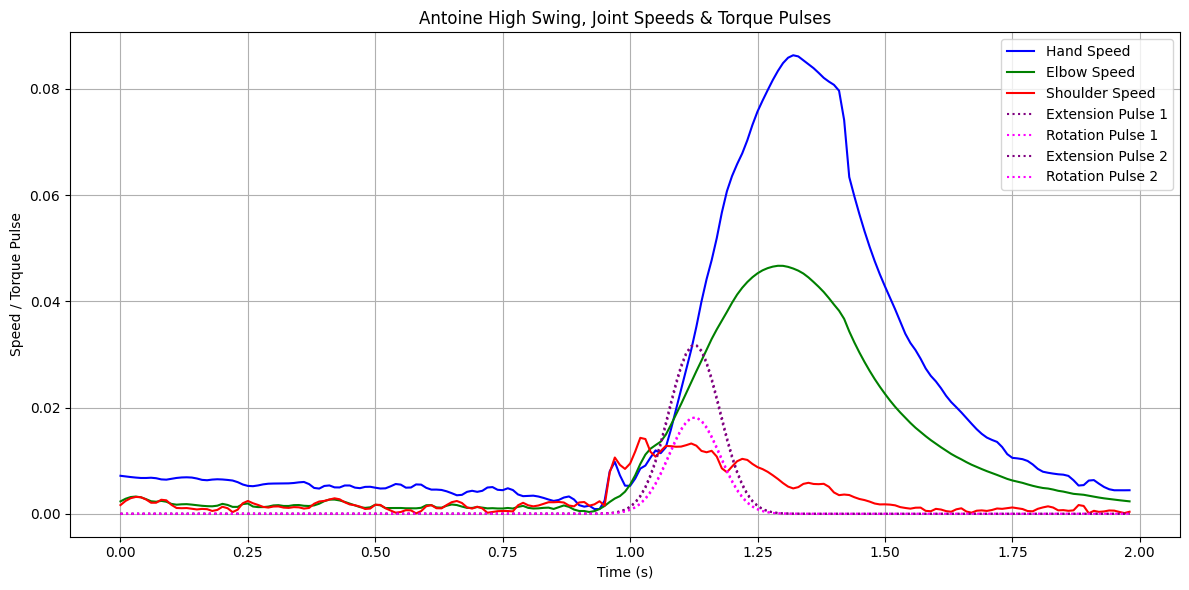

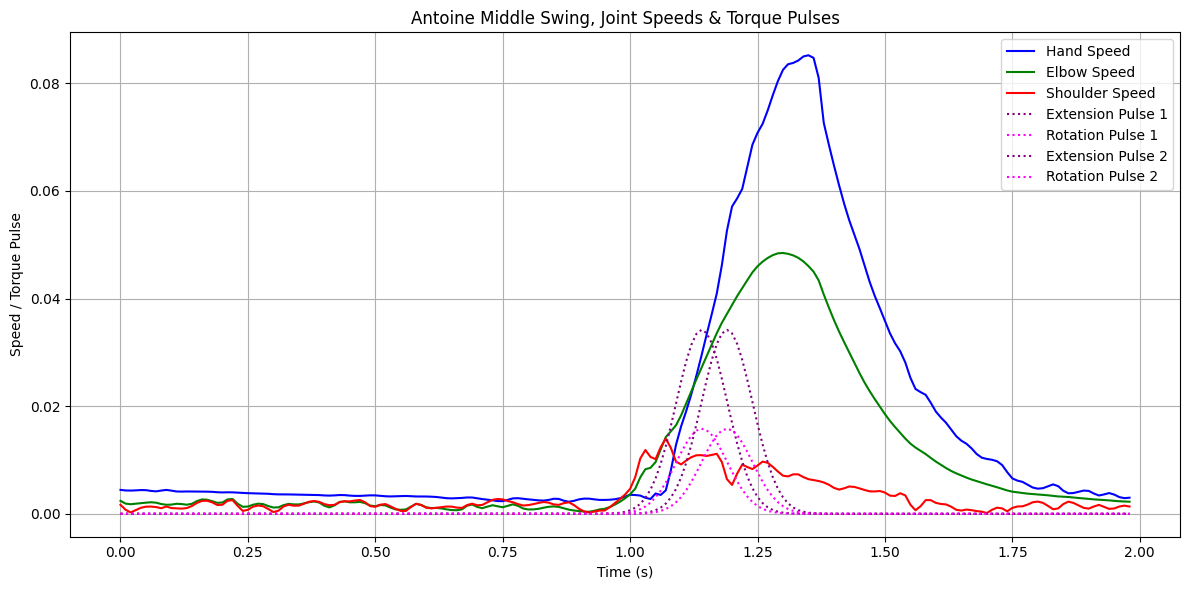

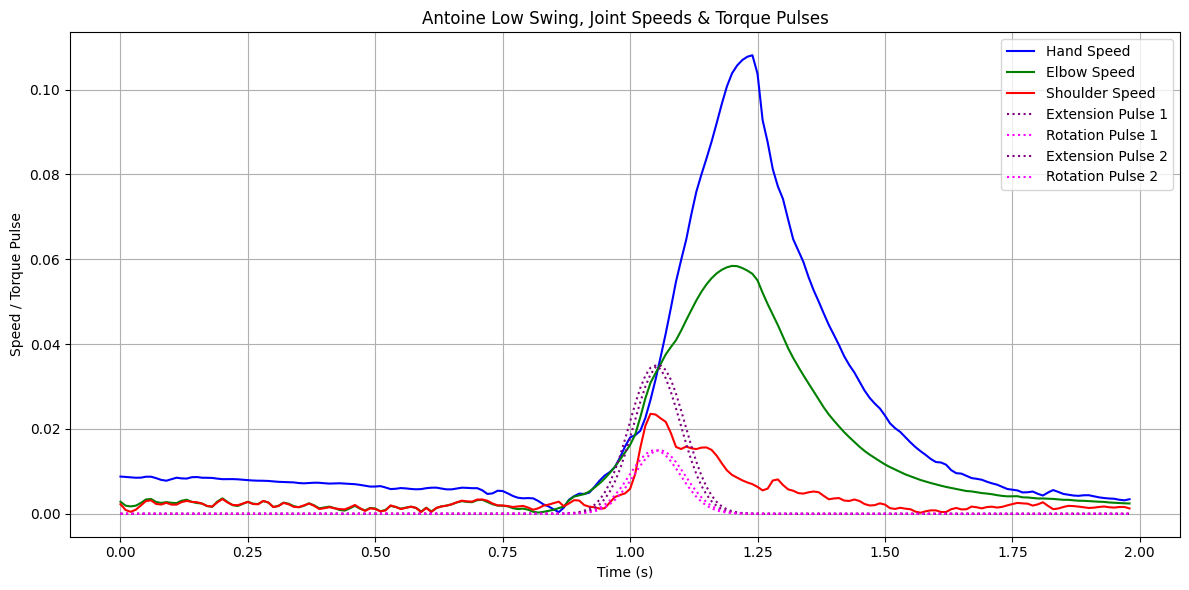

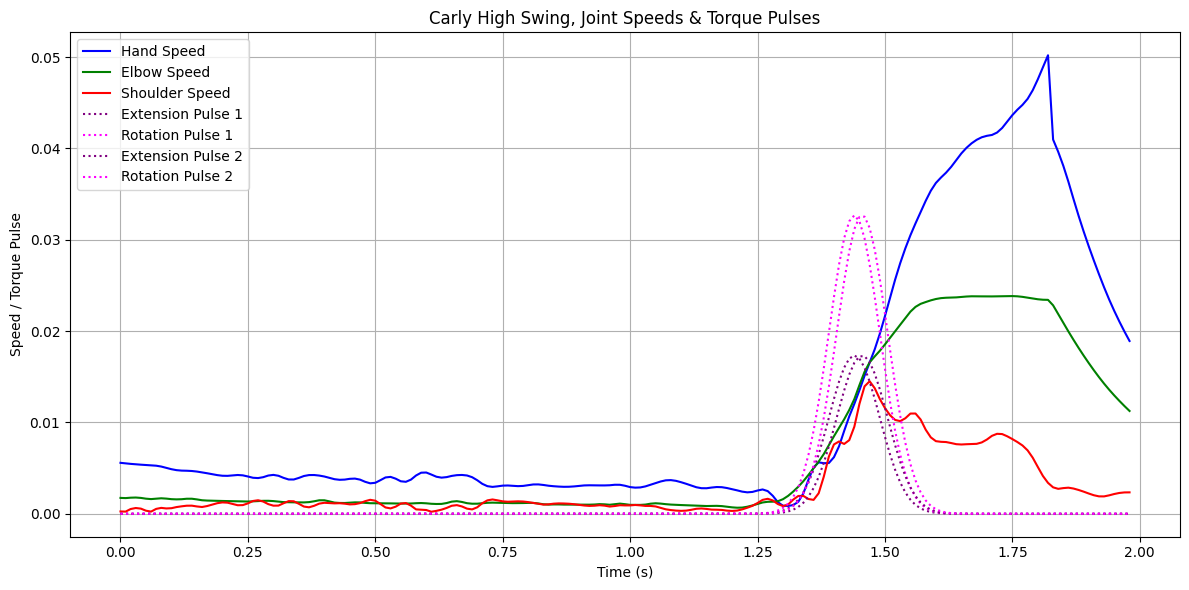

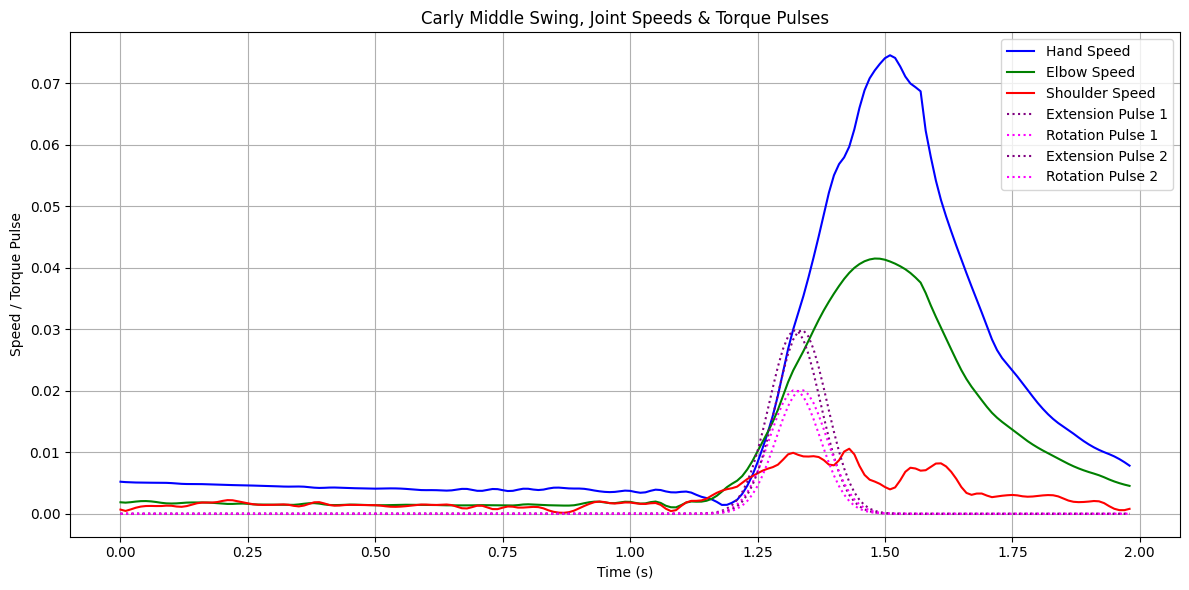

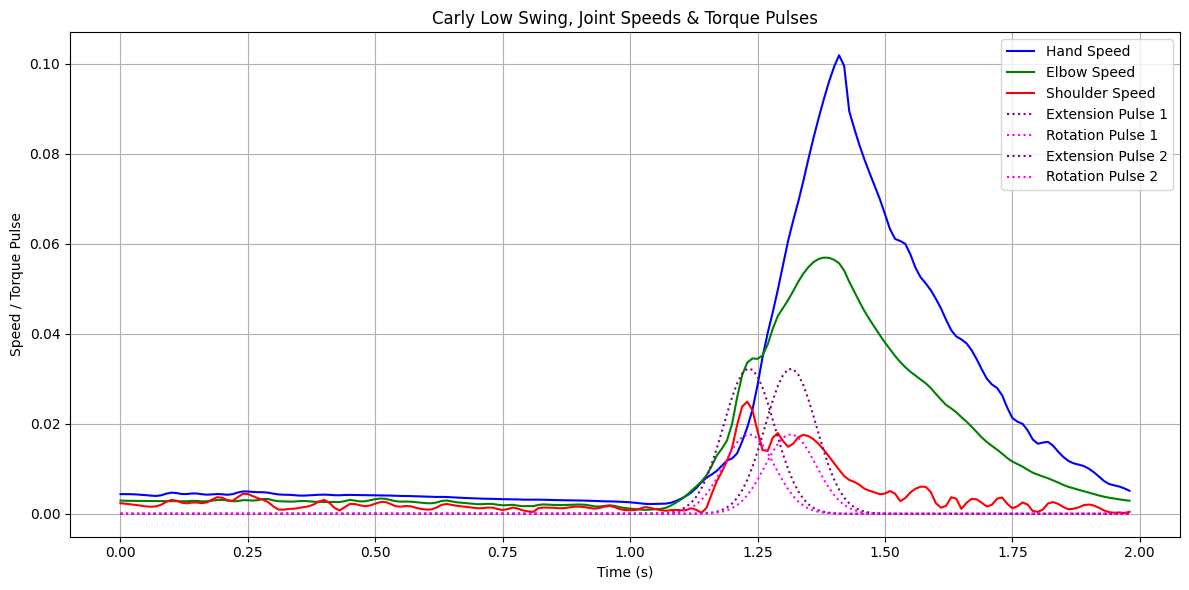

In [83]:
for person in people:
    for swing_type in swings:
        x_spline, y_spline = get_shoulder_path_from_file_name(f"{person}_{swing_type}")

        # pulse parameters
        theta1_center = optimal_parameters[person][swing_type]["impulse1"] * 2
        theta2_center = optimal_parameters[person][swing_type]["impulse2"] * 2
        phi1_center = optimal_parameters[person][swing_type]["impulse1"] * 2
        phi2_center = optimal_parameters[person][swing_type]["impulse2"] * 2
        extension_power = 2.2
        rotation_power = 0.08

        m2Node = Node(m2, None, l2)
        m1Node = Node(m1, m2Node, l1)
        dp = DoublePendulum3D([None, m1Node, m2Node], drag, g, [x_spline, y_spline], 1.0)

        er_ratio = optimal_parameters[person][swing_type]["er_ratio"]
        extension_power = 2.2 * er_ratio
        rotation_power = 0.08 * (1 - er_ratio)
        dp.set_peak_times_and_powers(theta1_center, theta2_center, theta1_center, theta2_center, extension_power, rotation_power)
        shoulders, elbows, hands, states = dp.run_simulation(init_states[person][swing_type], t_max, sim_dt)
        
        # speeds
        hand_speeds = np.linalg.norm(np.diff(hands, axis=0), axis=1)
        elbow_speeds = np.linalg.norm(np.diff(elbows, axis=0), axis=1)
        shoulder_speeds = np.linalg.norm(np.diff(shoulders, axis=0), axis=1)
    
        time = np.arange(len(hand_speeds)) * sim_dt
        
        # gaussian plots
        def biomechanic_torque_pulse(t, center, power, sigma=0.05):
            return power * np.exp(-0.5 * ((t - center) / sigma) ** 2) * .05
        
        tau_pulse1_extension = biomechanic_torque_pulse(time, theta1_center, optimal_parameters[person][swing_type]["er_ratio"])
        tau_pulse1_rotation = biomechanic_torque_pulse(time, theta1_center, (1 - optimal_parameters[person][swing_type]["er_ratio"]))
        
        tau_pulse2_extension = biomechanic_torque_pulse(time, theta2_center, optimal_parameters[person][swing_type]["er_ratio"])
        tau_pulse2_rotation = biomechanic_torque_pulse(time, theta2_center, (1 - optimal_parameters[person][swing_type]["er_ratio"]))
        
        # plott
        plt.figure(figsize=(12, 6))
        
        # joint speeds
        plt.plot(time, hand_speeds, label='Hand Speed', color='blue')
        plt.plot(time, elbow_speeds, label='Elbow Speed', color='green')
        plt.plot(time, shoulder_speeds, label='Shoulder Speed', color='red')
        
        # torque pulses
        plt.plot(time, tau_pulse1_extension, ':', label='Extension Pulse 1', color='purple')
        plt.plot(time, tau_pulse1_rotation, ':', label='Rotation Pulse 1', color='magenta')
        plt.plot(time, tau_pulse2_extension, ':', label='Extension Pulse 2', color='purple')
        plt.plot(time, tau_pulse2_rotation, ':', label='Rotation Pulse 2', color='magenta')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Speed / Torque Pulse')
        plt.title(f"{person.capitalize()} {swing_type.capitalize()} Swing, Joint Speeds & Torque Pulses")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

## Joint Speed and Torque Pulse Analysis

These plots illustrate how biomechanical torque pulses, representing muscular impulses, interact with joint kinematics over the course of each volleyball swing using the 3D pendulum model.

The timing of these pulses is critical. For each swing, the first pair of torque pulses targets the shoulder joint and is synchronized with the point of peak shoulder acceleration. The second pair of pulses targets the elbow and is optimized from the previous methods of parameter sweeping or Monte Carlo.

### Timing and Coordination Across Swing Styles

Across all plots, the hand reaches its maximum speed shortly after the torque pulses peak, showing that the applied torques are effectively translated into forward motion, which is great as this is what happens in volleyball swings from the footage. The separation in timing between the shoulder and elbow pulses allows energy to flow sequentially from the shoulder to the elbow and the optimization mimics an atheletes coordination.

For Antoine (me), this transfer is most evident in the low (circular) swing, where hand speed peaks sharply just after a clean pair of well-timed elbow impulses. In contrast, my high swing shows closer spacing between pulses, and the hand speed peak is slightly delayed and lower in magnitude. This suggests that while all swings are coordinated, the circular swing achieves the most effective timing between segments.

Carly shows a similar trend, but with some variation. Her low swing produces the highest hand velocity overall, surpassing even my own, and the pulse shapes appear slightly more spread out. This spacing indicates a smoother torque application, possibly reflecting a more controlled or gradual acceleration strategy. Interestingly, her high and middle swings appear slightly less efficient: although the elbow speed rises significantly, it doesn't always translate into a proportionally larger hand speed. This suggests some energy is dissipated or mistimed between joints, but more data would be needed to verify this.


### Efficiency and Energy Transfer

A key metric of swing efficiency is how well the energy from joint torques is transferred into linear hand velocity. In the most efficient cases—typically the low swings for both of us, the shoulder and elbow speeds ramp up in a staggered but continuous pattern, with torque pulses arriving slightly before each joint’s velocity increase. This phase alignment ensures that each segment receives force at the right time to amplify rather than resist motion.

I noticed less efficient swings show more overlap between torque pulses and premature peaking of joint speeds, which can result in energy being spent counterproductively. For example in my middle swing, the shoulder speed peaks early, and although the elbow pulse is timed to follow, the resulting hand velocity is slightly lower than in the low swing, indicating suboptimal energy conversion.

Comparing our swings, my swings in the modelgenerally show sharper, more abrupt increases in elbow and hand speed, reflecting a more explosive style, whereas Carly’s plots show more gradual speed ramps but often result in higher peak hand velocities, especially in her low swing. 


## Animating the Swings

The following code block animates the optimal swings for each swing entry within the model, with a XY projection showing thetas (same angle as the camera from the footage) and ZY projections as if the camera was behind the athlete.

In [ ]:
plt.rcParams['animation.embed_limit'] = 100
from matplotlib.patches import Arc
from matplotlib import colormaps
from IPython.display import display, HTML  # Import display

cmap = colormaps['coolwarm']

for person in people:
    for swing_type in swings:
        x_spline, y_spline = get_shoulder_path_from_file_name(f"{person}_{swing_type}")

        theta1_center = optimal_parameters[person][swing_type]["impulse1"] * 2
        theta2_center = optimal_parameters[person][swing_type]["impulse2"] * 2
        phi1_center = optimal_parameters[person][swing_type]["impulse1"] * 2
        phi2_center = optimal_parameters[person][swing_type]["impulse2"] * 2
        extension_power = 2.2
        rotation_power = 0.08

        m2Node = Node(m2, None, l2)
        m1Node = Node(m1, m2Node, l1)
        init_state = init_states[person][swing]
        er_ratio = optimal_parameters[person][swing_type]["er_ratio"]
        extension_power = 2.2 * er_ratio
        rotation_power = 0.08 * (1 - er_ratio)
        dp = DoublePendulum3D([None, m1Node, m2Node], drag, g, [x_spline, y_spline], 1.0)
        dp.set_peak_times_and_powers(theta1_center, theta2_center, theta1_center, theta2_center, extension_power, rotation_power)
        pivots, elbows, hands, states = dp.run_simulation(init_states[person][swing_type], t_max, sim_dt)
        
        num_steps = len(shoulders)

        def signed_angle_deg(v1, v2):
            angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
            return np.degrees(angle) % 360

        fig = plt.figure(figsize=(18, 6))
        
        # 3D view
        ax3d = fig.add_subplot(131, projection='3d')
        ax3d.set_title(f"{person.capitalize()} {swing_type.capitalize()} Swing: 3D View")
        ax3d.set_xlim(-2, 1); ax3d.set_ylim(-1, 1); ax3d.set_zlim(-0.5, 0.5)
        line3d, = ax3d.plot([], [], [], '-', lw=2, color='black')
        dot_p, = ax3d.plot([], [], [], 'o', markersize=6)
        dot_e, = ax3d.plot([], [], [], 'o', markersize=6)
        dot_h, = ax3d.plot([], [], [], 'o', markersize=6)
        trace_p, = ax3d.plot([], [], [], '-', lw=1, color='k', alpha=0.5)
        trace_e, = ax3d.plot([], [], [], '-', lw=1, color='g', alpha=0.5)
        trace_h, = ax3d.plot([], [], [], '-', lw=1, color='r', alpha=0.5)
        ax3d.view_init(elev=80, azim=-90)

        # XY
        ax_xy = fig.add_subplot(132)
        ax_xy.set_title(f"{person.capitalize()} {swing_type.capitalize()} Swing: XY Projection")
        ax_xy.set_xlim(-2, 1); ax_xy.set_ylim(-1, 1); ax_xy.set_aspect('equal')
        line_xy, = ax_xy.plot([], [], '-', lw=2, color='black')
        dot_p_xy, = ax_xy.plot([], [], 'o', markersize=6)
        dot_e_xy, = ax_xy.plot([], [], 'o', markersize=6)
        dot_h_xy, = ax_xy.plot([], [], 'o', markersize=6)
        trace_p_xy, = ax_xy.plot([], [], '-', lw=1, color='k', alpha=0.5)
        trace_e_xy, = ax_xy.plot([], [], '-', lw=1, color='g', alpha=0.5)
        trace_h_xy, = ax_xy.plot([], [], '-', lw=1, color='r', alpha=0.5)
        arc_xy_shoulder = Arc((0, 0), 0.2, 0.2, color='black')
        arc_xy_elbow = Arc((0, 0), 0.2, 0.2, color='black')
        angle_text_xy_s = ax_xy.text(0, 0, "", fontsize=8)
        angle_text_xy_e = ax_xy.text(0, 0, "", fontsize=8)
        ax_xy.add_patch(arc_xy_shoulder)
        ax_xy.add_patch(arc_xy_elbow)

        # ZY
        ax_zy = fig.add_subplot(133)
        ax_zy.set_title(f"{person.capitalize()} {swing_type.capitalize()} Swing: ZY Projection")
        ax_zy.set_xlim(-0.5, 0.5); ax_zy.set_ylim(-1, 1); ax_zy.set_aspect('equal')
        line_zy, = ax_zy.plot([], [], '-', lw=2, color='black')
        dot_p_zy, = ax_zy.plot([], [], 'o', markersize=6)
        dot_e_zy, = ax_zy.plot([], [], 'o', markersize=6)
        dot_h_zy, = ax_zy.plot([], [], 'o', markersize=6)
        trace_p_zy, = ax_zy.plot([], [], '-', lw=1, color='k', alpha=0.5)
        trace_e_zy, = ax_zy.plot([], [], '-', lw=1, color='g', alpha=0.5)
        trace_h_zy, = ax_zy.plot([], [], '-', lw=1, color='r', alpha=0.5)
        arc_zy_shoulder = Arc((0, 0), 0.2, 0.2, color='black')
        arc_zy_elbow = Arc((0, 0), 0.2, 0.2, color='black')
        angle_text_zy_s = ax_zy.text(0, 0, "", fontsize=8)
        angle_text_zy_e = ax_zy.text(0, 0, "", fontsize=8)
        ax_zy.add_patch(arc_zy_shoulder)
        ax_zy.add_patch(arc_zy_elbow)

        def animate(i):
            p = pivots[i]
            e = elbows[i]
            h = hands[i]
        
            if i == 0:
                c_p = c_e = c_h = cmap(0.0)
            else:
                v_p = np.linalg.norm(p - pivots[i - 1]) / sim_dt
                v_e = np.linalg.norm(e - elbows[i - 1]) / sim_dt
                v_h = np.linalg.norm(h - hands[i - 1]) / sim_dt
                c_p = cmap(min(v_p / 10.0, 1.0))
                c_e = cmap(min(v_e / 10.0, 1.0))
                c_h = cmap(min(v_h / 10.0, 1.0))
        
            line3d.set_data([p[0], e[0], h[0]], [p[1], e[1], h[1]])
            line3d.set_3d_properties([p[2], e[2], h[2]])
            dot_p.set_data([p[0]], [p[1]]); dot_p.set_3d_properties([p[2]]); dot_p.set_color(c_p)
            dot_e.set_data([e[0]], [e[1]]); dot_e.set_3d_properties([e[2]]); dot_e.set_color(c_e)
            dot_h.set_data([h[0]], [h[1]]); dot_h.set_3d_properties([h[2]]); dot_h.set_color(c_h)
        
            piv_trace = np.array(pivots[:i+1])
            ele_trace = np.array(elbows[:i+1])
            han_trace = np.array(hands[:i+1])
            trace_p.set_data(piv_trace[:,0], piv_trace[:,1]); trace_p.set_3d_properties(piv_trace[:,2])
            trace_e.set_data(ele_trace[:,0], ele_trace[:,1]); trace_e.set_3d_properties(ele_trace[:,2])
            trace_h.set_data(han_trace[:,0], han_trace[:,1]); trace_h.set_3d_properties(han_trace[:,2])

            line_xy.set_data([p[0], e[0], h[0]], [p[1], e[1], h[1]])
            dot_p_xy.set_data([p[0]], [p[1]]); dot_p_xy.set_color(c_p)
            dot_e_xy.set_data([e[0]], [e[1]]); dot_e_xy.set_color(c_e)
            dot_h_xy.set_data([h[0]], [h[1]]); dot_h_xy.set_color(c_h)
            trace_p_xy.set_data(piv_trace[:,0], piv_trace[:,1])
            trace_e_xy.set_data(ele_trace[:,0], ele_trace[:,1])
            trace_h_xy.set_data(han_trace[:,0], han_trace[:,1])
    
            upper_vec_xy = np.array([e[0] - p[0], e[1] - p[1]])
            lower_vec_xy = np.array([h[0] - e[0], h[1] - e[1]])
            theta1 = (np.degrees(np.arctan2(upper_vec_xy[1], upper_vec_xy[0]))) % 360
            theta2 = (np.degrees(np.arctan2(lower_vec_xy[1], lower_vec_xy[0]))) % 360
            arc_xy_shoulder.center = (p[0], p[1]); arc_xy_shoulder.theta2 = theta1
            arc_xy_elbow.center = (e[0], e[1]); arc_xy_elbow.theta2 = theta2
            angle_text_xy_s.set_position((p[0] + 0.1, p[1] + 0.1)); angle_text_xy_s.set_text(f"{round(theta1)}°")
            angle_text_xy_e.set_position((e[0] + 0.1, e[1] + 0.1)); angle_text_xy_e.set_text(f"{round(theta2)}°")
        
            line_zy.set_data([p[2], e[2], h[2]], [p[1], e[1], h[1]])
            dot_p_zy.set_data([p[2]], [p[1]]); dot_p_zy.set_color(c_p)
            dot_e_zy.set_data([e[2]], [e[1]]); dot_e_zy.set_color(c_e)
            dot_h_zy.set_data([h[2]], [h[1]]); dot_h_zy.set_color(c_h)
            trace_p_zy.set_data(piv_trace[:,2], piv_trace[:,1])
            trace_e_zy.set_data(ele_trace[:,2], ele_trace[:,1])
            trace_h_zy.set_data(han_trace[:,2], han_trace[:,1])
    
            upper_vec_zy = np.array([e[2] - p[2], e[1] - p[1]])
            lower_vec_zy = np.array([h[2] - e[2], h[1] - e[1]])
            phi1 = (np.degrees(np.arctan2(upper_vec_zy[1], upper_vec_zy[0]))) % 360
            phi2 = (np.degrees(np.arctan2(lower_vec_zy[1], lower_vec_zy[0]))) % 360
            arc_zy_shoulder.center = (p[2], p[1]); arc_zy_shoulder.theta2 = phi1
            arc_zy_elbow.center = (e[2], e[1]); arc_zy_elbow.theta2 = phi2
            angle_text_zy_s.set_position((p[2] + 0.05, p[1] + 0.1)); angle_text_zy_s.set_text(f"{round(phi1)}°")
            angle_text_zy_e.set_position((e[2] + 0.05, e[1] + 0.1)); angle_text_zy_e.set_text(f"{round(phi2)}°")
        
            return (
                line3d, dot_p, dot_e, dot_h, trace_p, trace_e, trace_h,
                line_xy, dot_p_xy, dot_e_xy, dot_h_xy, trace_p_xy, trace_e_xy, trace_h_xy,
                line_zy, dot_p_zy, dot_e_zy, dot_h_zy, trace_p_zy, trace_e_zy, trace_h_zy,
                arc_xy_shoulder, arc_xy_elbow, angle_text_xy_s, angle_text_xy_e,
                arc_zy_shoulder, arc_zy_elbow, angle_text_zy_s, angle_text_zy_e
            )
            
        ani = animation.FuncAnimation(
            fig,
            animate,
            frames=range(0, num_steps, 2),  # skip every other frame
            interval=sim_dt * 1000 * 2,     # double time per frame to keep real-time speed
            blit=False
        )
        plt.close(fig)
        html = HTML(ani.to_jshtml())
        display(html)

## Max Hand Speed Results by Swing Type

This bar chart summarizes the maximum hand speed achieved for each swing type by each athlete. The results align well with biomechanical intuition: the lower the hand draft during the swing, the greater the hand speed output.


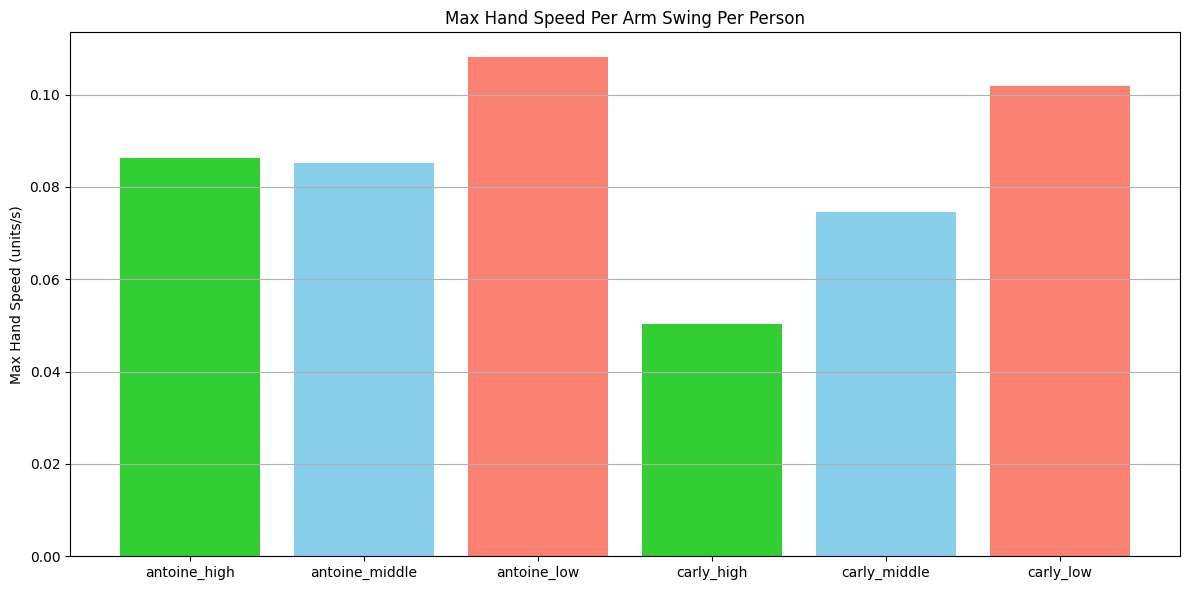

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# dictionary to store max speeds
max_speeds = {}

for person in people:
    for swing_type in swings:
        x_spline, y_spline = get_shoulder_path_from_file_name(f"{person}_{swing_type}")

        # pulse parameters
        theta1_center = optimal_parameters[person][swing_type]["impulse1"] * 2
        theta2_center = optimal_parameters[person][swing_type]["impulse2"] * 2
        er_ratio = optimal_parameters[person][swing_type]["er_ratio"]
        extension_power = 2.2 * er_ratio
        rotation_power = 0.08 * (1 - er_ratio)

        m2Node = Node(m2, None, l2)
        m1Node = Node(m1, m2Node, l1)
        dp = DoublePendulum3D([None, m1Node, m2Node], drag, g, [x_spline, y_spline], 1.0)

        dp.set_peak_times_and_powers(
            theta1_center, theta2_center, theta1_center, theta2_center,
            extension_power, rotation_power
        )

        shoulders, elbows, hands, states = dp.run_simulation(init_states[person][swing_type], t_max, sim_dt)

        # compute hand speeds and store max
        hand_speeds = np.linalg.norm(np.diff(hands, axis=0), axis=1)
        max_speed = np.max(hand_speeds)
        max_speeds[f"{person}_{swing_type}"] = max_speed


labels = list(max_speeds.keys())
values = list(max_speeds.values())

colors = []
for label in labels:
    if "high" in label:
        colors.append("limegreen")
    elif "middle" in label:
        colors.append("skyblue")
    elif "low" in label:
        colors.append("salmon")
    else:
        colors.append("light gray")

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=colors)
plt.xticks(rotation=0)
plt.ylabel('Max Hand Speed (units/s)')
plt.title('Max Hand Speed Per Arm Swing Per Person')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Both me and Carly show a clear trend "low" or "circular" swings, produce the highest peak speeds, followed by "middle" (bow-and-arrow), and then "high" (straight) swings for Carly. For me, high and middle were almost the same. This confirms that lower swing paths allow for better momentum buildup, likely due to increased torque leverage and a longer arc.  This suggests that the simulation is capturing realistic and interpretable physical effects, and could be a tool used by volleyball coaches and athletes alike, showing them how they could maximize their swing. For myself, compared to the empirical data, I could improve on my circular swing to generate even more power than my current optimal bow-and-arrow swing.

## Conclusion

The computational model successfully captures the essential biomechanics of a volleyball arm swing. Using a 3D double pendulum framework driven by empirical shoulder trajectories and controlled by Gaussian torque pulses, the simulation produces physically realistic results that align with human intuition and athletic technique.

The most important result learned from my model is that lower swing drafts consistently lead to greater hand speeds, confirming that the circular swing path enables better energy transfer and momentum buildup. Of course, different swings have different purposes in volleyball, but in cases where a player has sufficient time to build up power (like for a serve or in a high set ball), a circulare arm swing is powerful. This is why you see athletes like Yuji Nishida, the outside hitter for the Japan's international team, generate so much power in his hits because of his ciruclar swings. In my simulations, this also held for both my swings and Carly's, despite our clear stylistic differences in impulse timing from the data and coordination strategies from the videos.

The pulse timing optimization, particularly the use of Monte Carlo sampling, proved efficient and effective in identifying optimal parameters. The separation of shoulder and elbow impulses, when well-timed, resulted in smoother acceleration curves and higher peak velocities. This insight could inform training tools or swing analysis software that emphasizes sequencing and joint coordination.

While the model effectively captures joint coordination and swing timing, it simplifies the arm as rigid links with fixed masses and ignores muscle fatigue, joint limits, and soft tissue dynamics. It also assumes perfect torque delivery, which doesn't reflect real-world variability in muscle force generation or neural delay. Future improvements could involve incorporating muscle activation models, subject-specific mass and inertia estimates, and inverse dynamics from real motion data to better match physiological behavior.

While my model makes simplifications, including rigid segments and ideal torques, it opens the door for future work: incorporating muscle fatigue, variable mass distribution, and data-driven mass estimation. This project shows that computational physics tools can provide meaningful insight into biomechanical motion, particularly when paired with modern pose-tracking techniques and numerical optimization.


## References

1. L. Seminati, A. Franchi, M. Bignardi, and F. Barbero, "Upper limb joint kinematics and coordination patterns in volleyball spike and serve," J. Sports Sci., 1906–1916 (2015).  

2. A. Reeser, M. Fleisig, D. Bolt, and J. Ruan, "Upper limb biomechanics during the volleyball spike," Br. J. Sports Med., 521–524 (2010).  

3. K. Kwon, J. Lee, Y. Lee, and K. Kim, "Three-dimensional kinematic analysis of volleyball spike jump between elite and amateur players," Korean J. Sport Biomech., 205–213 (2013).  

4. S. Wang and M. Liu, "Application of deep learning in biomechanical analysis of volleyball spike swing," J. Sports Med. Phys. Fitness, 845–853 (2022).  

5. F. E. Ziv and R. Lidor, "Vertical jump in female and male volleyball players: A review of observational and experimental studies," Scand. J. Med. Sci. Sports, 556–567 (2010).

6. G. Casiez, N. Roussel, and D. Vogel, "1€ Filter: A simple speed-based low-pass filter for noisy input in interactive systems," in *Proceedings of the SIGCHI Conference on Human Factors in Computing Systems* (ACM, New York, 2012), pp. 2527–2530.

7. Chaturvedi, N. A., Lee, T., Leok, M., & McClamroch, N. H. Nonlinear Dynamics of the 3D Pendulum.



